In [ ]:
from keras.models import *
from keras.layers import *
from keras import backend as K
import numpy as np
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
from numpy import asarray
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def binary_focal_loss(gamma, alpha, beta):
    """
    Binary form of focal loss.
         Focal loss for binary classification problems
    
    focal_loss(p_t) = -alpha_t * (1 - p_t)**gamma * log(p_t)
        where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    alpha = tf.constant(alpha, dtype=tf.float32)
    gamma = tf.constant(gamma, dtype=tf.float32)

    def binary_focal_loss_fixed(y_true, y_pred):
        """
        y_true shape need be (None,1)
        y_pred need be compute after sigmoid
        """
        y_true = tf.cast(y_true, tf.float32)
        alpha_t = y_true*alpha + (K.ones_like(y_true)-y_true)*(1-alpha)
    
        p_t = y_true*y_pred + (K.ones_like(y_true)-y_true)*(K.ones_like(y_true)-y_pred) + K.epsilon()
        fl = - alpha_t * K.pow((K.ones_like(y_true)-p_t),gamma) * K.log(p_t)
        fl = K.mean(fl)
        fl = beta * fl
        return fl
    return binary_focal_loss_fixed

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [ ]:
def preprocess_image(loc):
    img = Image.open(loc)
    img = img.resize((256,192))
    pixel = asarray(img)
    pixel = pixel / 255
    return pixel

In [ ]:
def show(img):
    img2 = img[:,:,::-1]
    plt.imshow(img2)

In [ ]:
def draw_result(image, result):
    img = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
#     mask = cv2.normalize(region_gt, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    result = cv2.normalize(result.reshape(192,256), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    ret,th = cv2.threshold(result,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#     ret2,th2 = cv2.threshold(mask,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    contours = []
    gabungan_contours,_ = cv2.findContours(th, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#     mask_contours,_ = cv2.findContours(th2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#     contours.append(mask_contours)
    contours.append(gabungan_contours)

    main = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    for i,c in enumerate(contours):
        if i == 0:
            color = (0,255,255)
        else:
            color = (0,0,255) #mask

        cv2.drawContours(main,c,-1,color,1)
    return main

In [ ]:
def segmented(image, result):
    img = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    resultz = cv2.normalize(result, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    ret,th = cv2.threshold(resultz,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    gabungan_contours,_ = cv2.findContours(th, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    img_contours = sorted(gabungan_contours, key=cv2.contourArea)
    mask = np.zeros(img.shape[:2], np.uint8)
    for i in img_contours:
        cv2.drawContours(mask, [i], -1, 255, -1)
    seg = cv2.bitwise_and(img,img,mask = mask)
    return seg

In [ ]:
def results(loc, model):
    inp = preprocess_image(loc)
    img = np.expand_dims(inp, axis=2).astype('float32')
    img = np.expand_dims(img, axis=0).astype('float32')
    result = model.predict(img)
    gabung = result[0] + result[1]
    draw = draw_result(inp, gabung)
    segment = segmented(inp, gabung.reshape(192,256))
    return inp, draw, segment

In [ ]:
model = load_model("/content/drive/MyDrive/Yolla Faradhilla - 05111950010029/Output/Percobaan Bobot DAL/300 RFNC + DAL (Region 0.8, Boundary 0.2).h5", custom_objects={'dice_coef': dice_coef, 'binary_focal_loss_fixed' : binary_focal_loss(gamma = 2., alpha = 0.25, beta = 0.8)})

In [ ]:
loc = '/content/drive/MyDrive/Yolla Faradhilla - 05111950010029/Data Kanal Mandibula/Augmentation/Images/(12).bmp'

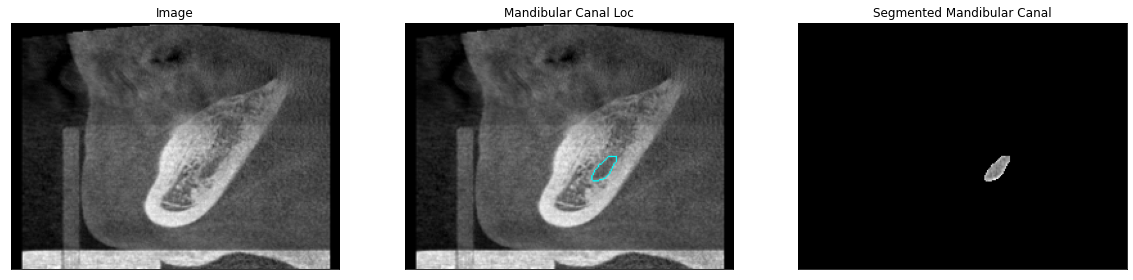

In [ ]:
image, hasil, kanal = results(loc, model)
fig = plt.figure(figsize=(20, 20))
plt.subplot(1,3,1),plt.imshow(image,cmap = 'gray')
plt.title('Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(hasil,cmap = 'gray')
plt.title('Mandibular Canal Loc'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(kanal,cmap = 'gray')
plt.title('Segmented Mandibular Canal'), plt.xticks([]), plt.yticks([])
plt.show()